### Import necessary packages and the scikit-learn diabetes dataset

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import sys
sys.path.append('../')

from tabularmagic import TabularMagic
import tabularmagic.ml.discriminative as mlmodels

diabetes_data = load_diabetes()
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
df['target'] = diabetes_data.target
display(df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Create a TabularMagic object

In [2]:
tm = TabularMagic(df, test_size=0.2, verbose=True)
tm.save_data_checkpoint('test')
print(tm)

UPDATE: TabularMagic initialization complete. Shapes of train, test datasets: (353, 11), (89, 11)
UPDATE: Working datasets checkpoint "test" saved.
TabularMagic
-----------------------------------------------------
Train shape: (353, 11)     |     Test shape: (89, 11)
-----------------------------------------------------
Categorical variables: None
                                                     
Continuous variables: age, sex, bmi, bp, s1, s2, s3,
s4, s5, s6, target


### Exploratory data analysis

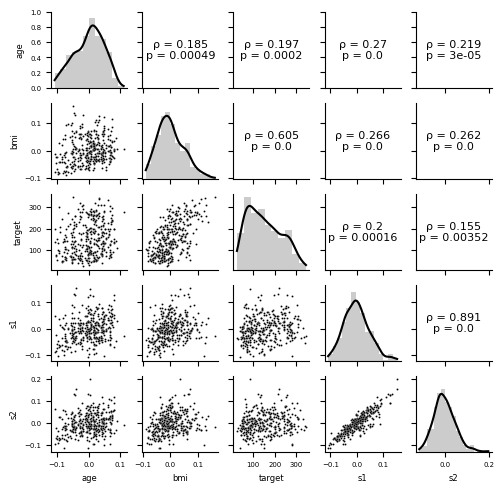

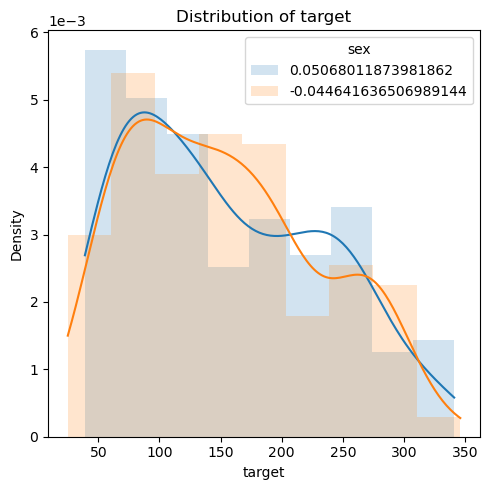

In [5]:

train_eda = tm.eda()
display(train_eda.plot_continuous_pairs(continuous_vars=['age', 'bmi', 'target', 's1', 's2']))
display(train_eda.plot_distribution_stratified('target', 'sex', include_hist=True))
pca_labels = train_eda.df['sex'] == train_eda.df['sex'].unique()[0]

### Basic regression analysis

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     138.2
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           4.99e-59
Time:                        15:17:45   Log-Likelihood:                -1942.0
No. Observations:                 353   AIC:                             3892.
Df Residuals:                     349   BIC:                             3908.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        149.7828      3.695     40.540      0.0

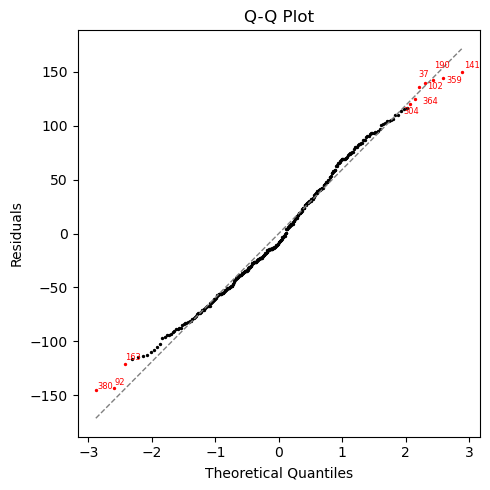

In [6]:
X_vars = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
y_var = 'target'
train_report, test_report = tm.lm_rlike('target ~ bmi + bp + bp * bmi')
train_report.set_outlier_threshold(2)
print(train_report.statsmodels_summary())
train_report.plot_qq(standardized=False, show_outliers=True)

### Save data checkpoint, drop outliers, rerun regression

UPDATE: Working datasets reset to original datasets. Shapes of train, test datasets: (353, 11), (89, 11)
UPDATE: Dropped rows [380, 364, 141, 304, 163, 92, 37, 190, 359, 102]. Shapes of train, test datasets: (343, 11), (89, 11)
UPDATE: Working datasets checkpoint "drop_checkpoint" saved.


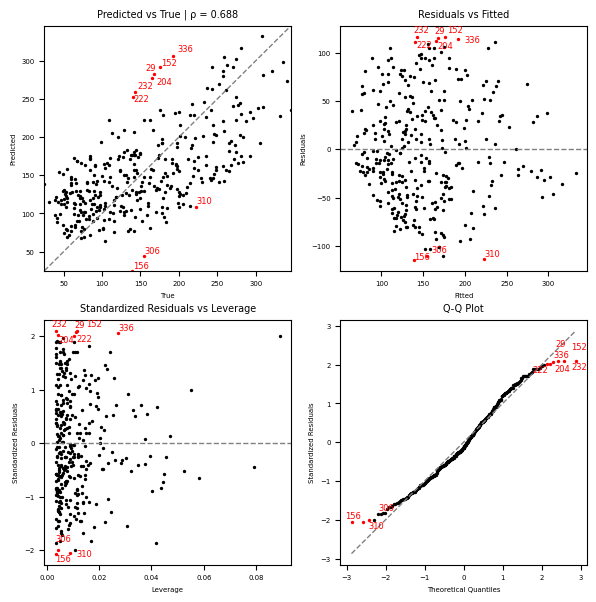

In [7]:
tm.load_data_checkpoint()
tm.drop_train_examples(train_report.get_outlier_indices())
tm.save_data_checkpoint('drop_checkpoint')
train_report, test_report = tm.lm_rlike('target ~ bmi + bp + bp * bmi', inverse_scale_y=True)
display(train_report.plot_diagnostics(show_outliers=True))

### Define a sequence of models

In [6]:
models = [
    # All models have default hyperparameter search methods built in.
    mlmodels.LinearR(regularization_type='OLS', n_jobs=-1),
    mlmodels.LinearR(regularization_type='l1', n_jobs=-1),
    mlmodels.LinearR(regularization_type='l2', n_jobs=-1),

    # You can manually set the inner cross validation details
    mlmodels.TreeR(n_jobs=-1, random_state=42, inner_cv=10, inner_cv_seed=0, 
         verbose=1),

    mlmodels.TreeEnsembleR(ensemble_type='random_forest', n_jobs=-1, random_state=42),
    mlmodels.TreeEnsembleR(ensemble_type='xgboost', n_jobs=-1),

    # You can manually set the nickname of a model
    mlmodels.SVMR(kernel='rbf', nickname='SupportVectorMachine(rbf)', n_jobs=-1),
    
    # You can manually specify the hypeparameter search method
    # in an sklearn-like manner. 
    mlmodels.MLPR(
        hyperparam_search_method='grid',
        hyperparam_grid_specification={
            'hidden_layer_sizes': [(50), (100), (50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200]
        }
    )
]

### Conduct a benchmarking exercise with the specified models

In [7]:
train_report, test_report = tm.ml_regression_benchmarking(
    X_vars=X_vars,
    y_var=y_var,
    models=models,
    outer_cv=None,
)

UPDATE: Task 1 of 8.	Fitting LinearR(OLS).
UPDATE: Task 2 of 8.	Fitting LinearR(l1).
UPDATE: Task 3 of 8.	Fitting LinearR(l2).
UPDATE: Task 4 of 8.	Fitting TreeR.
Fitting 10 folds for each of 27 candidates, totalling 270 fits
UPDATE: Task 5 of 8.	Fitting TreeEnsembleR(random_forest).
UPDATE: Task 6 of 8.	Fitting TreeEnsembleR(xgboost).
UPDATE: Task 7 of 8.	Fitting SupportVectorMachine(rbf).
UPDATE: Task 8 of 8.	Fitting MLPR.


### View the train and test model metrics

In [8]:
display(train_report._fit_statistics)

,LinearR(OLS),LinearR(l1),LinearR(l2),TreeR,TreeEnsembleR(random_forest),TreeEnsembleR(xgboost),SupportVectorMachine(rbf),MLPR
Statistic,,,,,,,,
mse,2512.431877,2528.223718,2521.640693,2774.179185,1412.800003,2691.058277,2254.640084,3174.178676
mad,40.986725,41.266835,41.124544,42.291462,31.231929,44.529868,37.276019,47.391179
pearsonr,0.743216,0.741682,0.742327,0.711151,0.872845,0.798932,0.776318,0.679740
spearmanr,0.722678,0.721021,0.721788,0.702346,0.846906,0.772278,0.756857,0.671438
r2,0.552370,0.549556,0.550729,0.505735,0.748287,0.520545,0.598300,0.434469
adjr2,0.541584,0.538702,0.539903,0.493825,0.742222,0.508992,0.588620,0.420842
n,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000


In [9]:
display(test_report._fit_statistics)

,LinearR(OLS),LinearR(l1),LinearR(l2),TreeR,TreeEnsembleR(random_forest),TreeEnsembleR(xgboost),SupportVectorMachine(rbf),MLPR
Statistic,,,,,,,,
mse,2884.847915,2910.684206,2900.667659,3267.405093,1926.908917,3135.250638,2667.768656,3498.270820
mad,43.488880,43.826403,43.657697,45.249685,34.548118,47.248607,40.048434,49.498906
pearsonr,0.717025,0.714394,0.715405,0.670783,0.828345,0.757799,0.745625,0.660630
spearmanr,0.699802,0.696993,0.698747,0.673377,0.814961,0.743946,0.732398,0.656155
r2,0.513507,0.509150,0.510839,0.448994,0.675051,0.471280,0.550115,0.410061
adjr2,0.502219,0.497761,0.499490,0.436209,0.667512,0.459012,0.539676,0.396373
n,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000


### View the predicted vs true scatter plot of the SVM model on testing data.

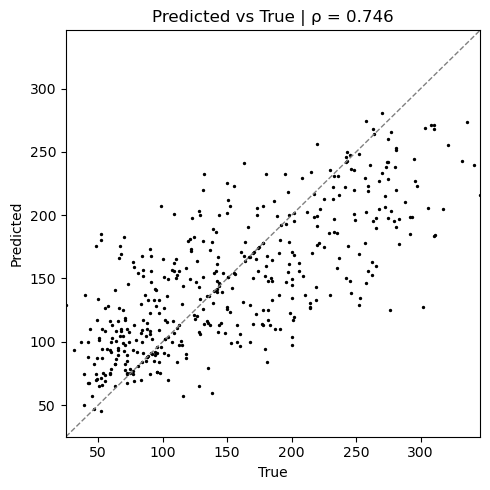

In [10]:
fig = test_report['SupportVectorMachine(rbf)'].plot_pred_vs_true()
fig